In [1]:
#This was a group final project for my Machine Learning 1 class I did while completing my Masters at
#Georgetown University. The project builds on the regression models in previous projects and dives into
#Decision Trees and Random Forest Models. A written report also goes deep into the analysis of this project.
#the project goes in detail about the consequences of employee turnover and how to predict employee turnover
#given certain parameters. I left the original comments to help you understand the thought process in that
#moment for what we were trying to accomplish.

In [2]:
#Some packages are no longer supported by R or Kaggle/githubinstall such as Hmisc and car. However,
#I have commented out those lines of code and replaced them with comments so you understand the train of
#thought. 

In [3]:
library(readxl)
HR_Data = read_excel("/kaggle/input/employee-data/Employee_Data_Project.xlsx")

In [4]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(class)
library(caret)
library(data.table)
library(ROCR)
library(ROSE) #sampling over and under, ROC and AUC curve 
#library(car)
library(rpart)
#library(ranger)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following 

In [5]:
#The Ranger and Car package are not supported in Kaggle's cache. I still complete a Random Forest using
#the randomforest package. I have included the code still for the ranger package to be reviewed if 
#necessary.

In [6]:
dim(HR_Data) #understanding dimensions
names(HR_Data) #naming convention of HRDATA
str(HR_Data) #classifications of BikeData
anyNA(HR_Data)  #Checking for any NA
sum(apply(HR_Data, 1, anyNA)) #checkings data to understand anyNA double check
##NOTES: WE DO HAVE SOME NAS THAT WILL NEED TO TREATED BEFORE CONTINUING

[1] 4410   18

[1] "Age"                     "Attrition"              
 [3] "BusinessTravel"          "DistanceFromHome"       
 [5] "Education"               "EmployeeID"             
 [7] "Gender"                  "JobLevel"               
 [9] "MaritalStatus"           "Income"                 
[11] "NumCompaniesWorked"      "StandardHours"          
[13] "TotalWorkingYears"       "TrainingTimesLastYear"  
[15] "YearsAtCompany"          "YearsWithCurrManager"   
[17] "EnvironmentSatisfaction" "JobSatisfaction"

tibble [4,410 × 18] (S3: tbl_df/tbl/data.frame)
 $ Age                    : num [1:4410] 51 31 32 38 32 46 28 29 31 25 ...
 $ Attrition              : chr [1:4410] "No" "Yes" "No" "No" ...
 $ BusinessTravel         : chr [1:4410] "Travel_Rarely" "Travel_Frequently" "Travel_Frequently" "Non-Travel" ...
 $ DistanceFromHome       : num [1:4410] 6 10 17 2 10 8 11 18 1 7 ...
 $ Education              : num [1:4410] 2 1 4 5 1 3 2 3 3 4 ...
 $ EmployeeID             : num [1:4410] 1 2 3 4 5 6 7 8 9 10 ...
 $ Gender                 : chr [1:4410] "Female" "Female" "Male" "Male" ...
 $ JobLevel               : num [1:4410] 1 1 4 3 1 4 2 2 3 4 ...
 $ MaritalStatus          : chr [1:4410] "Married" "Single" "Married" "Married" ...
 $ Income                 : num [1:4410] 131160 41890 193280 83210 23420 ...
 $ NumCompaniesWorked     : chr [1:4410] "1" "0" "1" "3" ...
 $ StandardHours          : num [1:4410] 8 8 8 8 8 8 8 8 8 8 ...
 $ TotalWorkingYears      : chr [1:4410] "1" "6" "5" "13" ...
 $ Tr

[1] FALSE

[1] 0

In [7]:
table(HR_Data$Attrition)
prop.table(table(HR_Data$Attrition))
summary(HR_Data)
##Only 16.1% of our Y variable is in the data, may need to under sample


  No  Yes 
3699  711 


       No       Yes 
0.8387755 0.1612245 

      Age         Attrition         BusinessTravel     DistanceFromHome
 Min.   :18.00   Length:4410        Length:4410        Min.   : 1.000  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 2.000  
 Median :36.00   Mode  :character   Mode  :character   Median : 7.000  
 Mean   :36.92                                         Mean   : 9.193  
 3rd Qu.:43.00                                         3rd Qu.:14.000  
 Max.   :60.00                                         Max.   :29.000  
   Education       EmployeeID      Gender             JobLevel    
 Min.   :1.000   Min.   :   1   Length:4410        Min.   :1.000  
 1st Qu.:2.000   1st Qu.:1103   Class :character   1st Qu.:1.000  
 Median :3.000   Median :2206   Mode  :character   Median :2.000  
 Mean   :2.913   Mean   :2206                      Mean   :2.064  
 3rd Qu.:4.000   3rd Qu.:3308                      3rd Qu.:3.000  
 Max.   :5.000   Max.   :4410                      Max.   :5.000  
 MaritalStatus          Inc

In [8]:
set.seed(123) #setting to be reproducible
index <- sample(1:nrow(HR_Data),round(nrow(HR_Data)*0.7)) #setting up to split the data
train<- HR_Data[index,] #training data
test<- HR_Data[-index,] #test data

#Ensure proportionality of test and training is same
table(test$Attrition)
prop.table(table(test$Attrition))
table(train$Attrition)
prop.table(table(train$Attrition))

#since both are roughly the same proportions, we can proceed


  No  Yes 
1108  215 


       No       Yes 
0.8374906 0.1625094 


  No  Yes 
2591  496 


       No       Yes 
0.8393262 0.1606738 

In [9]:
library(hablar)

train_factor = train %>%
  convert(fct(Attrition, BusinessTravel, Gender, MaritalStatus, JobLevel, Education))

#the following variables should be converted to numeric as some are charcaters: total working years, numcompaniesworked, education, environmentsatisfaction, job satisfaction; when we did a missing data check, the missing data was not detected because the original data structure was different i.e. total working years - was a character, num companies worked was a charcter.
train_numeric = train_factor %>% 
  convert(num(TotalWorkingYears, NumCompaniesWorked, JobSatisfaction))

train = train_numeric

#convert test data from character to factor; 
test_factor = test %>%
  convert(fct(BusinessTravel, Gender, MaritalStatus, Attrition, JobLevel, Education))

#convert test data from charcter to numeric, this way we would be able to detect missing data 
test_numeric = test_factor%>% 
  convert(num(TotalWorkingYears, NumCompaniesWorked, JobSatisfaction))

test = test_numeric


Attaching package: ‘hablar’


The following object is masked from ‘package:forcats’:

    fct


The following object is masked from ‘package:dplyr’:

    na_if


The following object is masked from ‘package:tibble’:

    num


Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TotalWorkingYears = (structure(function (..., .x = ..1, .y =
  ..2, . = ..1) ...`.
Caused by warning in `as_reliable_num()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TotalWorkingYears = (structure(function (..., .x = ..1, .y =
  ..2, . = ..1) ...`.
Caused by warning in `as_reliable_num()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


In [10]:
#Identify where missing values are
sapply(train,function(x)sum(is.na(x))) #NumCompaniesWorked = 14, TotalWorkingYears = 4, Environmentsatisfaction = 14, Jobsatisfaction = 18
sapply(test,function(x)sum(is.na(x))) #NumCompaniesWorked = 5, TotalWorkingYears = 5, EnvironmentSatisfaction = 11, JobSatisfaction = 2

#Replacing NumCompaniesWorked 
train$NumCompaniesWorked[is.na(train$NumCompaniesWorked)] = median(train$NumCompaniesWorked,na.rm = TRUE)
test$NumCompaniesWorked[is.na(test$NumCompaniesWorked)] = median(test$NumCompaniesWorked,na.rm = TRUE)

#Replacing TotalWorkingYears 
train$TotalWorkingYears[is.na(train$TotalWorkingYears)] = median(train$TotalWorkingYears,na.rm = TRUE)
test$TotalWorkingYears[is.na(test$TotalWorkingYears)] = median(test$TotalWorkingYears,na.rm = TRUE)

#Replacing EnvironmentSatisfaction
train$EnvironmentSatisfaction[is.na(train$EnvironmentSatisfaction)] = median(train$EnvironmentSatisfaction,na.rm = TRUE)
test$EnvironmentSatisfaction[is.na(test$EnvironmentSatisfaction)] = median(test$EnvironmentSatisfaction,na.rm = TRUE)

#Replacing Jobsatisfaction 
train$JobSatisfaction[is.na(train$JobSatisfaction)] = median(train$JobSatisfaction,na.rm = TRUE)
test$JobSatisfaction[is.na(test$JobSatisfaction)] = median(test$JobSatisfaction,na.rm = TRUE)

sapply(train,function(x)sum(is.na(x))) 
sapply(test,function(x)sum(is.na(x))) 
#successfully adjusted the NAs

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                      14                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      4                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                      18

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       5                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      5                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                       2

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       0                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      0                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                       0

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       0                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      0                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                       0

In [11]:
#Running the baseline regression model

Baseline_Reg = glm(Attrition~., data = train, family = binomial())
summary(Baseline_Reg)


Call:
glm(formula = Attrition ~ ., family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5323  -0.6037  -0.4080  -0.2332   2.7522  

Coefficients: (1 not defined because of singularities)
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.721e-01  4.864e-01   0.354 0.723541    
Age                             -2.511e-02  8.372e-03  -3.000 0.002704 ** 
BusinessTravelTravel_Frequently  1.554e+00  2.542e-01   6.114 9.72e-10 ***
BusinessTravelTravel_Rarely      7.794e-01  2.406e-01   3.239 0.001199 ** 
DistanceFromHome                 5.679e-03  6.705e-03   0.847 0.397012    
Education2                       5.576e-02  1.950e-01   0.286 0.774921    
Education3                      -9.517e-02  1.782e-01  -0.534 0.593331    
Education4                      -3.173e-02  1.879e-01  -0.169 0.865923    
Education5                      -6.372e-01  3.775e-01  -1.688 0.091361 .  
EmployeeI

In [12]:
#Undersampling both the test and training data

library(ROSE)

train_under = ovun.sample(formula = Attrition ~., 
                          data = train, 
                          method = "under",
                          p=0.5, seed = 123)$data
table(train_under$Attrition)

test_under = ovun.sample(formula = Attrition ~., 
                          data = test, 
                          method = "under",
                          p=0.5, seed = 123)$data
table(test_under$Attrition)
#proportion is fairly balanced in test data 


 No Yes 
488 496 


 No Yes 
202 215 

In [13]:
#With a balanced sample using undersampling, we run a logistic regression to test improvement

model_1 = glm(Attrition ~., family= "binomial", data = train_under)
summary(model_1)
#The new model has far lower residuals at 1162 with an AIC of 1212.5  versus the former model of 2315.8 
#and AIC of 2365.8. Both were below null which si good. Since down sampling has lower AIC, we proceed with it.


Call:
glm(formula = Attrition ~ ., family = "binomial", data = train_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3718  -0.9953   0.3308   0.9829   2.0369  

Coefficients: (1 not defined because of singularities)
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.237e+00  6.477e-01   1.910 0.056145 .  
Age                             -2.375e-02  1.092e-02  -2.174 0.029687 *  
BusinessTravelTravel_Frequently  1.656e+00  3.243e-01   5.108 3.26e-07 ***
BusinessTravelTravel_Rarely      9.519e-01  2.999e-01   3.174 0.001504 ** 
DistanceFromHome                 8.908e-03  9.252e-03   0.963 0.335629    
Education2                       3.919e-01  2.688e-01   1.458 0.144946    
Education3                      -1.425e-01  2.390e-01  -0.596 0.550965    
Education4                       1.348e-01  2.496e-01   0.540 0.589014    
Education5                      -6.805e-01  4.890e-01  -1.392 0.164061    
Emp

In [14]:
#Having completed the cleaning process, we now use stepwise to remove insignificant variables 

step_model1 = step(model_1, direction = "both")
formula(step_model1) 
#Attrition ~ Age + BusinessTravel + JobLevel + MaritalStatus + Income + NumCompaniesWorked + TotalWorkingYears + TrainingTimesLastYear + YearsAtCompany + YearsWithCurrManager + EnvironmentSatisfaction + JobSatisfaction

#The Model removed the following variables as insignificant: Distance from home, Education, Employee ID, Gender, Job Level, Income, Standard Hours

summary(step_model1)
#Most influential over the data: Businesses Travel, Number of Companies Worked For, Years at company, Years with current manager, Job Satisfaction

Start:  AIC=1206.85
Attrition ~ Age + BusinessTravel + DistanceFromHome + Education + 
    EmployeeID + Gender + JobLevel + MaritalStatus + Income + 
    NumCompaniesWorked + StandardHours + TotalWorkingYears + 
    TrainingTimesLastYear + YearsAtCompany + YearsWithCurrManager + 
    EnvironmentSatisfaction + JobSatisfaction


Step:  AIC=1206.85
Attrition ~ Age + BusinessTravel + DistanceFromHome + Education + 
    EmployeeID + Gender + JobLevel + MaritalStatus + Income + 
    NumCompaniesWorked + TotalWorkingYears + TrainingTimesLastYear + 
    YearsAtCompany + YearsWithCurrManager + EnvironmentSatisfaction + 
    JobSatisfaction

                          Df Deviance    AIC
- Gender                   1   1150.9 1204.9
- EmployeeID               1   1151.0 1205.0
- DistanceFromHome         1   1151.8 1205.8
- Income                   1   1152.8 1206.8
<none>                         1150.8 1206.8
- Education                4   1160.8 1208.8
- Age                      1   1155.6 1209.6


Attrition ~ Age + BusinessTravel + Education + JobLevel + MaritalStatus + 
    Income + NumCompaniesWorked + TotalWorkingYears + TrainingTimesLastYear + 
    YearsAtCompany + YearsWithCurrManager + EnvironmentSatisfaction + 
    JobSatisfaction


Call:
glm(formula = Attrition ~ Age + BusinessTravel + Education + 
    JobLevel + MaritalStatus + Income + NumCompaniesWorked + 
    TotalWorkingYears + TrainingTimesLastYear + YearsAtCompany + 
    YearsWithCurrManager + EnvironmentSatisfaction + JobSatisfaction, 
    family = "binomial", data = train_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3941  -0.9982   0.3402   0.9856   1.9994  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.377e+00  6.144e-01   2.241 0.025007 *  
Age                             -2.305e-02  1.089e-02  -2.117 0.034283 *  
BusinessTravelTravel_Frequently  1.637e+00  3.218e-01   5.086 3.66e-07 ***
BusinessTravelTravel_Rarely      9.388e-01  2.977e-01   3.154 0.001613 ** 
Education2                       3.901e-01  2.685e-01   1.453 0.146278    
Education3                      -1.489e-01  2.384e-01  -0.625 0.532262    
Education4                       

In [15]:
#Check for multicollinearity

#vif(step_model1)
#none above 10, suggesting no multicollinearity

In [16]:
#Evaluate coefficients to get Odds Ratio

exp(coef(step_model1))

#Business Travel = with an increase in work travel, the odds of attrition 100*(4.64-1) = 364% increase likelihood of attrition
#Employees who have worked at a greater number of companies work for another: 100*(1.11-1) = 11% increase in attrition
#Years at company: 100*(1.083 - 1) = 8.3% increase in attrition
#years with current manager: (0.833 - 1)*100 = -16.7% decrease in attrition
#Job Satisfaction: a 1 point increase in job satisfaction leads to a 21.8% decrease in attrition

(Intercept)                             Age 
                      3.9629954                       0.9772122 
BusinessTravelTravel_Frequently     BusinessTravelTravel_Rarely 
                      5.1384174                       2.5568554 
                     Education2                      Education3 
                      1.4770575                       0.8616531 
                     Education4                      Education5 
                      1.1566620                       0.5023513 
                      JobLevel2                       JobLevel3 
                      1.0736979                       0.9568567 
                      JobLevel4                       JobLevel5 
                      2.2603916                       0.4073519 
           MaritalStatusMarried             MaritalStatusSingle 
                      1.5825197                       3.0152537 
                         Income              NumCompaniesWorked 
                      0.9999978                       1.1171284 
              TotalWorkingYears           TrainingTimesLastYear 
                      0.9404551                       0.8379936 
                 YearsAtCompany            YearsWithCurrManager 
                      1.0896266                       0.8300286 
       EnvironmentSatisfaction2        EnvironmentSatisfaction3 
                      0.4599019                       0.4759884 
       EnvironmentSatisfaction4       EnvironmentSatisfactionNA 
                      0.5499354                       1.4966906 
                JobSatisfaction 
                      0.7659483

In [17]:
#Run ANOVA test for step_model1 to confirm

anova(step_model1,test="Chisq")
#there is significance but we could try one additional model using Age, BusinessTravel, MaritalStatus,NumCOmpaniesWorkedfor,TotalWorkingyears, YearswithcurrentManager, and Jobsatisfaction

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,983,1364.049,NA
Age,1,29.40355585,982,1334.645,5.876971e-08
BusinessTravel,2,26.12803608,980,1308.517,2.120162e-06
Education,4,10.46484442,976,1298.052,3.328471e-02
JobLevel,4,8.22383786,972,1289.828,8.371442e-02
MaritalStatus,2,34.07692653,970,1255.751,3.983726e-08
Income,1,3.52203286,969,1252.229,6.055813e-02
NumCompaniesWorked,1,16.66251165,968,1235.567,4.465480e-05
TotalWorkingYears,1,15.95236760,967,1219.614,6.495648e-05


In [18]:
#Knowing our models odds, run a second version with management's assumptions for prediction. 
#Run a stepwise to clean up for potential. 

model_Mgmt = glm(Attrition ~ JobSatisfaction + TotalWorkingYears + YearsAtCompany, family = "binomial", data = train_under)
summary(model_Mgmt)
#residuals are only slightly below null and AIC 1314
##we find that years at company is not significant but total working years and job satisfaction are. YearsAtCompany had a p-value of 0.24

model_Mgmt2 = glm(Attrition ~ JobSatisfaction + TotalWorkingYears, family = "binomial", data = train_under)
summary(model_Mgmt2)
#residuals are very close to null and AIC increased to 1313.4

anova(model_Mgmt2,test="Chisq") #significant


Call:
glm(formula = Attrition ~ JobSatisfaction + TotalWorkingYears + 
    YearsAtCompany, family = "binomial", data = train_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5796  -1.1447   0.8228   1.0732   2.2541  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.19614    0.19638   6.091 1.12e-09 ***
JobSatisfaction   -0.21740    0.05909  -3.679 0.000234 ***
TotalWorkingYears -0.05093    0.01300  -3.919 8.88e-05 ***
YearsAtCompany    -0.01869    0.01602  -1.167 0.243140    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1364.0  on 983  degrees of freedom
Residual deviance: 1305.9  on 980  degrees of freedom
AIC: 1313.9

Number of Fisher Scoring iterations: 4



Call:
glm(formula = Attrition ~ JobSatisfaction + TotalWorkingYears, 
    family = "binomial", data = train_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5796  -1.1421   0.8229   1.0847   2.1220  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.191174   0.196135   6.073 1.25e-09 ***
JobSatisfaction   -0.221059   0.059006  -3.746 0.000179 ***
TotalWorkingYears -0.061177   0.009755  -6.271 3.58e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1364.0  on 983  degrees of freedom
Residual deviance: 1307.3  on 981  degrees of freedom
AIC: 1313.3

Number of Fisher Scoring iterations: 4


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,983,1364.049,NA
JobSatisfaction,1,13.08485,982,1350.964,2.976944e-04
TotalWorkingYears,1,43.68900,981,1307.275,3.849286e-11


In [19]:
#Next, run the marketing model to see what we learn. See if stepwise can improve the model

model_Mktg = glm(Attrition~Gender+Education+Age+MaritalStatus+Income, family = "binomial", data = train_under)
summary(model_Mktg)

#Age and Marital Status seem most important, potentially with income 
#Residuals only slightly below the null and AIC of 1310

step_Mktg2 = step(model_Mktg, direction = "both")
formula(step_Mktg2) 

#Model recommends keeping Age and Marital Status only 

summary(step_Mktg2)
#Only marginal improvement using stepwise function 

anova(step_Mktg2,test = "Chisq") #our deviance is significant since Age and Marital status are significant


Call:
glm(formula = Attrition ~ Gender + Education + Age + MaritalStatus + 
    Income, family = "binomial", data = train_under)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.654  -1.096   0.670   1.109   1.781  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           8.121e-01  3.849e-01   2.110   0.0349 *  
GenderMale           -1.542e-02  1.357e-01  -0.114   0.9095    
Education2            4.733e-01  2.433e-01   1.945   0.0518 .  
Education3            8.325e-02  2.150e-01   0.387   0.6986    
Education4            1.199e-01  2.283e-01   0.525   0.5993    
Education5           -4.946e-01  4.407e-01  -1.122   0.2617    
Age                  -3.430e-02  7.440e-03  -4.610 4.03e-06 ***
MaritalStatusMarried  2.976e-01  1.871e-01   1.590   0.1118    
MaritalStatusSingle   9.223e-01  1.902e-01   4.848 1.25e-06 ***
Income               -3.015e-06  1.415e-06  -2.131   0.0331 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

Start:  AIC=1309.65
Attrition ~ Gender + Education + Age + MaritalStatus + Income

                Df Deviance    AIC
- Gender         1   1289.7 1307.7
<none>               1289.7 1309.7
- Education      4   1297.8 1309.8
- Income         1   1294.2 1312.2
- Age            1   1311.5 1329.5
- MaritalStatus  2   1319.6 1335.6

Step:  AIC=1307.66
Attrition ~ Education + Age + MaritalStatus + Income

                Df Deviance    AIC
<none>               1289.7 1307.7
- Education      4   1297.9 1307.9
+ Gender         1   1289.7 1309.7
- Income         1   1294.2 1310.2
- Age            1   1311.5 1327.5
- MaritalStatus  2   1319.6 1333.6


Attrition ~ Education + Age + MaritalStatus + Income


Call:
glm(formula = Attrition ~ Education + Age + MaritalStatus + Income, 
    family = "binomial", data = train_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6570  -1.0937   0.6683   1.1066   1.7785  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           8.016e-01  3.736e-01   2.145   0.0319 *  
Education2            4.735e-01  2.433e-01   1.946   0.0516 .  
Education3            8.252e-02  2.149e-01   0.384   0.7010    
Education4            1.207e-01  2.282e-01   0.529   0.5967    
Education5           -4.951e-01  4.407e-01  -1.123   0.2613    
Age                  -3.426e-02  7.433e-03  -4.610 4.03e-06 ***
MaritalStatusMarried  2.977e-01  1.871e-01   1.591   0.1116    
MaritalStatusSingle   9.223e-01  1.902e-01   4.848 1.25e-06 ***
Income               -3.014e-06  1.415e-06  -2.130   0.0332 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family 

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,983,1364.049,NA
Education,4,7.829851,979,1356.219,9.801362e-02
Age,1,30.373332,978,1325.845,3.563942e-08
MaritalStatus,2,31.595520,976,1294.250,1.377590e-07
Income,1,4.586927,975,1289.663,3.221673e-02


In [20]:
#Now we proceed to predict with the test set in our base model and build confusion matrix

#adding predictions to test data and then going to check for accuracy with confusion matrix
Attrition_Predict = predict(object = step_model1, newdata = test_under, type = "response")
head(Attrition_Predict)
summary(Attrition_Predict)

test_under$predicted = ifelse(Attrition_Predict>=0.5,1,0)
head(test_under$predicted) 

levels(test_under$Attrition) <- c(0,1) #add levels to work confusion matrix

##CONFUSION MATRIX
table(test_under$predicted)
confusionMatrix(data=as.factor(test_under$predicted),
                reference = as.factor(test_under$Attrition),
                positive = "1")
#Model accuracy is 63.79%, kappa is 0.2754, sensitivity is 0.6419 and specificity 0.6337

length(Attrition_Predict)
length(test_under$Attrition)  # same length

length(test_under$predicted) #same length

1         2         3         4         5         6 
0.4052358 0.6113366 0.5713055 0.2807688 0.2670538 0.7781172

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04371 0.31008 0.49817 0.50026 0.68123 0.96624 

[1] 0 1 1 0 0 1


  0   1 
210 207 

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 131  79
         1  71 136
                                          
               Accuracy : 0.6403          
                 95% CI : (0.5922, 0.6864)
    No Information Rate : 0.5156          
    P-Value [Acc > NIR] : 1.842e-07       
                                          
                  Kappa : 0.2807          
                                          
 Mcnemar's Test P-Value : 0.5676          
                                          
            Sensitivity : 0.6326          
            Specificity : 0.6485          
         Pos Pred Value : 0.6570          
         Neg Pred Value : 0.6238          
             Prevalence : 0.5156          
         Detection Rate : 0.3261          
   Detection Prevalence : 0.4964          
      Balanced Accuracy : 0.6405          
                                          
       'Positive' Class : 1               
                              

[1] 417

[1] 417

[1] 417

In [21]:
#Next we run a confusion matrixes for the other two models to see if either are more optimal

#start with Management model -> #model_mgmt2
#adding predictions to test data and then going to check for accuracy with confusion matrix
Attrition_Predict_Mgmt = predict(object = model_Mgmt2, newdata = test_under, type = "response")
head(Attrition_Predict_Mgmt)
summary(Attrition_Predict_Mgmt)

test_under$predicted_MGMT = ifelse(Attrition_Predict_Mgmt>=0.5,1,0)
head(test_under$predicted_MGMT) 

levels(test_under$Attrition) <- c(0,1) #add levels to work confusion matrix

##CONFUSION MATRIX - Management Model
table(test_under$predicted_MGMT)
confusionMatrix(data=as.factor(test_under$predicted_MGMT),
                reference = as.factor(test_under$Attrition),
                positive = "1")
#Model accuracy is 0.6475%, kappa is 0.29, sensitivity is 0.7209  and specificity 0.5693

####################################################################RUN MARKETING#######################################
#start with Management model -> #step_Mktg2
#adding predictions to test data and then going to check for accuracy with confusion matrix
Attrition_Predict_MKTG = predict(object = step_Mktg2, newdata = test_under, type = "response")
head(Attrition_Predict_MKTG)
summary(Attrition_Predict_MKTG)

test_under$predicted_MKTG = ifelse(Attrition_Predict_MKTG>=0.5,1,0)
head(test_under$predicted_MKTG) 

levels(test_under$Attrition) <- c(0,1) #add levels to work confusion matrix

##CONFUSION MATRIX - Marketing Model
table(test_under$predicted_MKTG)
confusionMatrix(data=as.factor(test_under$predicted_MKTG),
                reference = as.factor(test_under$Attrition),
                positive = "1")
#Model accuracy is 0.6211%, kappa is 0.2403, sensitivity is 0.6558  and specificity 0.5842

1         2         3         4         5         6 
0.4943501 0.5155519 0.3947970 0.3327989 0.6179120 0.5703518

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1238  0.4244  0.5249  0.5000  0.5886  0.7128 

[1] 0 1 0 0 1 1


  0   1 
175 242 

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 115  60
         1  87 155
                                          
               Accuracy : 0.6475          
                 95% CI : (0.5995, 0.6933)
    No Information Rate : 0.5156          
    P-Value [Acc > NIR] : 3.62e-08        
                                          
                  Kappa : 0.2914          
                                          
 Mcnemar's Test P-Value : 0.032           
                                          
            Sensitivity : 0.7209          
            Specificity : 0.5693          
         Pos Pred Value : 0.6405          
         Neg Pred Value : 0.6571          
             Prevalence : 0.5156          
         Detection Rate : 0.3717          
   Detection Prevalence : 0.5803          
      Balanced Accuracy : 0.6451          
                                          
       'Positive' Class : 1               
                              

1         2         3         4         5         6 
0.4057612 0.6074226 0.6803529 0.3412908 0.3486457 0.6518781

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2245  0.3994  0.5196  0.5140  0.6287  0.8054 

[1] 0 1 1 0 0 1


  0   1 
192 225 

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 118  74
         1  84 141
                                          
               Accuracy : 0.6211          
                 95% CI : (0.5726, 0.6679)
    No Information Rate : 0.5156          
    P-Value [Acc > NIR] : 9.082e-06       
                                          
                  Kappa : 0.2403          
                                          
 Mcnemar's Test P-Value : 0.474           
                                          
            Sensitivity : 0.6558          
            Specificity : 0.5842          
         Pos Pred Value : 0.6267          
         Neg Pred Value : 0.6146          
             Prevalence : 0.5156          
         Detection Rate : 0.3381          
   Detection Prevalence : 0.5396          
      Balanced Accuracy : 0.6200          
                                          
       'Positive' Class : 1               
                              

In [22]:
#Run additional stepwise to try and optimize our model

step_model2 = step(step_model1, direction = "both")
formula(step_model2) 
#rerunning stepwise model had no impact

Start:  AIC=1201.93
Attrition ~ Age + BusinessTravel + Education + JobLevel + MaritalStatus + 
    Income + NumCompaniesWorked + TotalWorkingYears + TrainingTimesLastYear + 
    YearsAtCompany + YearsWithCurrManager + EnvironmentSatisfaction + 
    JobSatisfaction

                          Df Deviance    AIC
<none>                         1151.9 1201.9
- Income                   1   1154.0 1202.0
- Education                4   1162.2 1204.2
- Age                      1   1156.4 1204.4
- JobLevel                 4   1165.5 1207.5
- TrainingTimesLastYear    1   1160.6 1208.6
- TotalWorkingYears        1   1163.1 1211.1
- NumCompaniesWorked       1   1164.8 1212.8
- EnvironmentSatisfaction  4   1170.8 1212.8
- YearsAtCompany           1   1165.3 1213.3
- JobSatisfaction          1   1168.6 1216.6
- YearsWithCurrManager     1   1182.0 1230.0
- BusinessTravel           2   1184.1 1230.1
- MaritalStatus            2   1185.2 1231.2


Attrition ~ Age + BusinessTravel + Education + JobLevel + MaritalStatus + 
    Income + NumCompaniesWorked + TotalWorkingYears + TrainingTimesLastYear + 
    YearsAtCompany + YearsWithCurrManager + EnvironmentSatisfaction + 
    JobSatisfaction

In [23]:
#Run combined marketing and mgmt model significant variables 

#Management Model recommends keeping Job Satisfaction and TotalWorkingYears Status only 
#Marketing Model recommends keeping Age and Marital Status only 
Model_COMBO = glm(Attrition ~ JobSatisfaction + TotalWorkingYears + Age + MaritalStatus, family = "binomial", data = train_under)
summary(Model_COMBO)
#AIC is 1287.9, residuals 100 below null so some predictability 


Call:
glm(formula = Attrition ~ JobSatisfaction + TotalWorkingYears + 
    Age + MaritalStatus, family = "binomial", data = train_under)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.749  -1.096   0.685   1.084   2.107  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           0.812670   0.360990   2.251 0.024371 *  
JobSatisfaction      -0.213241   0.060059  -3.551 0.000384 ***
TotalWorkingYears    -0.048821   0.012644  -3.861 0.000113 ***
Age                  -0.008098   0.009634  -0.841 0.400595    
MaritalStatusMarried  0.358308   0.187716   1.909 0.056290 .  
MaritalStatusSingle   0.945599   0.190943   4.952 7.34e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1364.0  on 983  degrees of freedom
Residual deviance: 1275.8  on 978  degrees of freedom
AIC: 1287.8

Number of Fisher Scoring iterations: 4


Area under the curve (AUC): 0.641

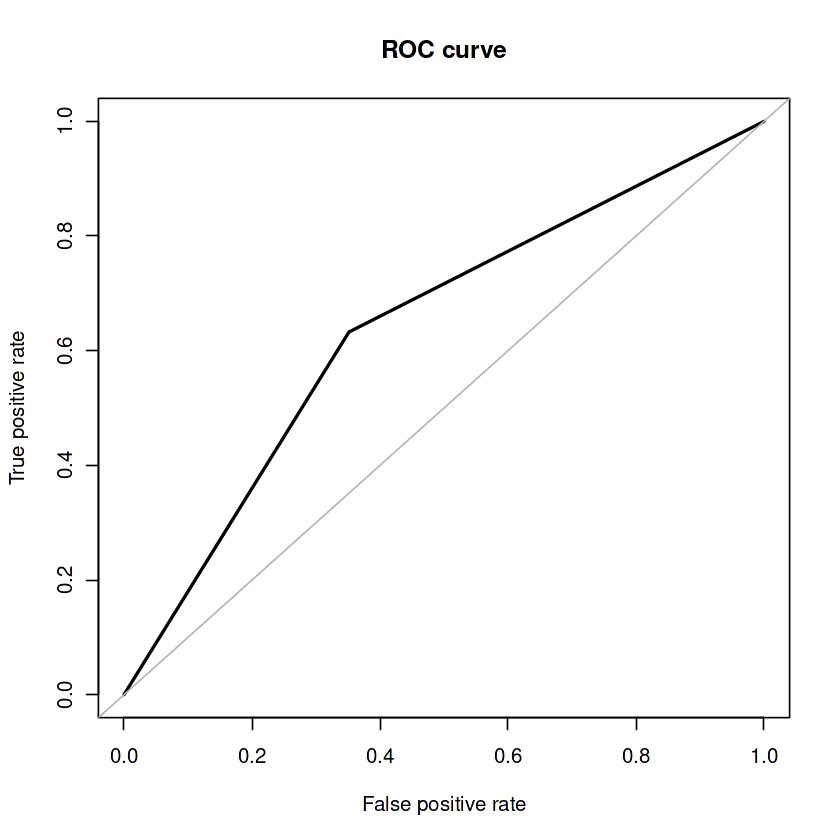

[1] 0.7414

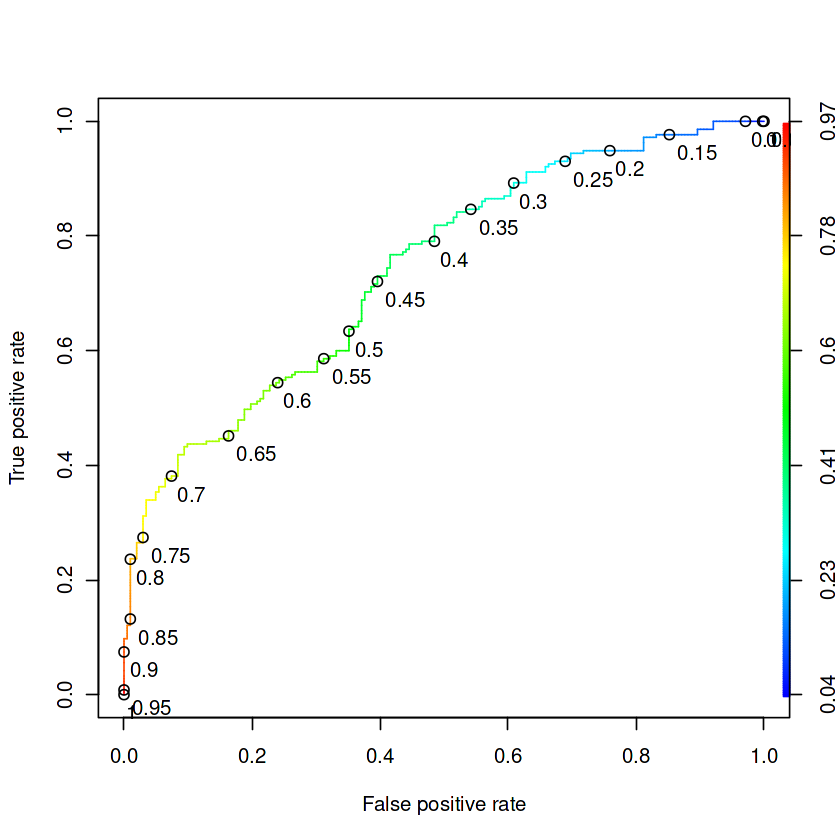

In [24]:
#Run ROC Curve 

#going to use my model prediction to run ROC
roc.curve(test_under$Attrition,test_under$predicted)

roc_pred = prediction(predictions = Attrition_Predict, labels = test_under$Attrition)
roc_perf = performance(roc_pred, "tpr" , "fpr")
plot(roc_perf,
     colorize = TRUE,
     print.cutoffs.at = seq(0,1,0.05),
     text.adj=c(-0.2,1.7))

as.numeric(performance(roc_pred,"auc")@y.values)
#AUC is 0.7334 which means the mode has a 73.3% chance to distinguish between a 0 and a 1

In [25]:
#Adjust threshold to predictor to see if that makes any impact on either model AND CHI SQUARE

Attrition_Predict2 = predict(object = step_model1, newdata = test_under, type = "response")
head(Attrition_Predict2)
summary(Attrition_Predict2)

test_under$predicted2 = ifelse(Attrition_Predict2>=0.45,1,0)
head(test_under$predicted2) 

levels(test_under$Attrition) <- c(0,1) #add levels to work confusion matrix

##CONFUSION MATRIX
table(test_under$predicted2)
confusionMatrix(data=as.factor(test_under$predicted2),
                reference = as.factor(test_under$Attrition),
                positive = "1")
#Model accuracy is 65.95%, kappa is 0.3131, sensitivity is 0.7860 and specificity 0.5248 ##MAY NOT BE GOOD

1         2         3         4         5         6 
0.4052358 0.6113366 0.5713055 0.2807688 0.2670538 0.7781172

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04371 0.31008 0.49817 0.50026 0.68123 0.96624 

[1] 0 1 1 0 0 1


  0   1 
183 234 

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 122  61
         1  80 154
                                          
               Accuracy : 0.6619          
                 95% CI : (0.6142, 0.7072)
    No Information Rate : 0.5156          
    P-Value [Acc > NIR] : 1.06e-09        
                                          
                  Kappa : 0.3212          
                                          
 Mcnemar's Test P-Value : 0.1296          
                                          
            Sensitivity : 0.7163          
            Specificity : 0.6040          
         Pos Pred Value : 0.6581          
         Neg Pred Value : 0.6667          
             Prevalence : 0.5156          
         Detection Rate : 0.3693          
   Detection Prevalence : 0.5612          
      Balanced Accuracy : 0.6601          
                                          
       'Positive' Class : 1               
                              


Call:
glm(formula = Attrition ~ BusinessTravel + MaritalStatus + NumCompaniesWorked + 
    TotalWorkingYears + YearsWithCurrManager + JobSatisfaction, 
    family = "binomial", data = train_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9613  -1.0572   0.5241   0.9950   2.1888  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.51646    0.37047  -1.394 0.163294    
BusinessTravelTravel_Frequently  1.57095    0.30933   5.078 3.80e-07 ***
BusinessTravelTravel_Rarely      0.93380    0.28473   3.280 0.001040 ** 
MaritalStatusMarried             0.48075    0.19453   2.471 0.013460 *  
MaritalStatusSingle              1.07549    0.19758   5.443 5.23e-08 ***
NumCompaniesWorked               0.08117    0.02809   2.889 0.003863 ** 
TotalWorkingYears               -0.04264    0.01202  -3.546 0.000391 ***
YearsWithCurrManager            -0.09239    0.02521  -3.665 0.000247 ***
JobSatisfaction 

(Intercept) BusinessTravelTravel_Frequently 
                      0.5966292                       4.8112015 
    BusinessTravelTravel_Rarely            MaritalStatusMarried 
                      2.5441517                       1.6172818 
            MaritalStatusSingle              NumCompaniesWorked 
                      2.9314370                       1.0845533 
              TotalWorkingYears            YearsWithCurrManager 
                      0.9582530                       0.9117493 
                JobSatisfaction 
                      0.7952284

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,983,1364.049,NA
BusinessTravel,2,28.05663,981,1335.992,8.083145e-07
MaritalStatus,2,40.15125,979,1295.841,1.911028e-09
NumCompaniesWorked,1,8.46525,978,1287.375,3.619956e-03
TotalWorkingYears,1,42.86185,977,1244.514,5.874510e-11
YearsWithCurrManager,1,12.54669,976,1231.967,3.969093e-04
JobSatisfaction,1,13.86321,975,1218.104,1.966099e-04


1         2         3         4         5         6 
0.3396055 0.6568432 0.5339954 0.3397057 0.3277236 0.4639011

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08759 0.36032 0.50503 0.49775 0.64523 0.87428 

[1] 0 1 1 0 0 0


  0   1 
207 210 

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 136  71
         1  66 144
                                          
               Accuracy : 0.6715          
                 95% CI : (0.6241, 0.7164)
    No Information Rate : 0.5156          
    P-Value [Acc > NIR] : 8.171e-11       
                                          
                  Kappa : 0.3428          
                                          
 Mcnemar's Test P-Value : 0.7325          
                                          
            Sensitivity : 0.6698          
            Specificity : 0.6733          
         Pos Pred Value : 0.6857          
         Neg Pred Value : 0.6570          
             Prevalence : 0.5156          
         Detection Rate : 0.3453          
   Detection Prevalence : 0.5036          
      Balanced Accuracy : 0.6715          
                                          
       'Positive' Class : 1               
                              

Area under the curve (AUC): 0.672

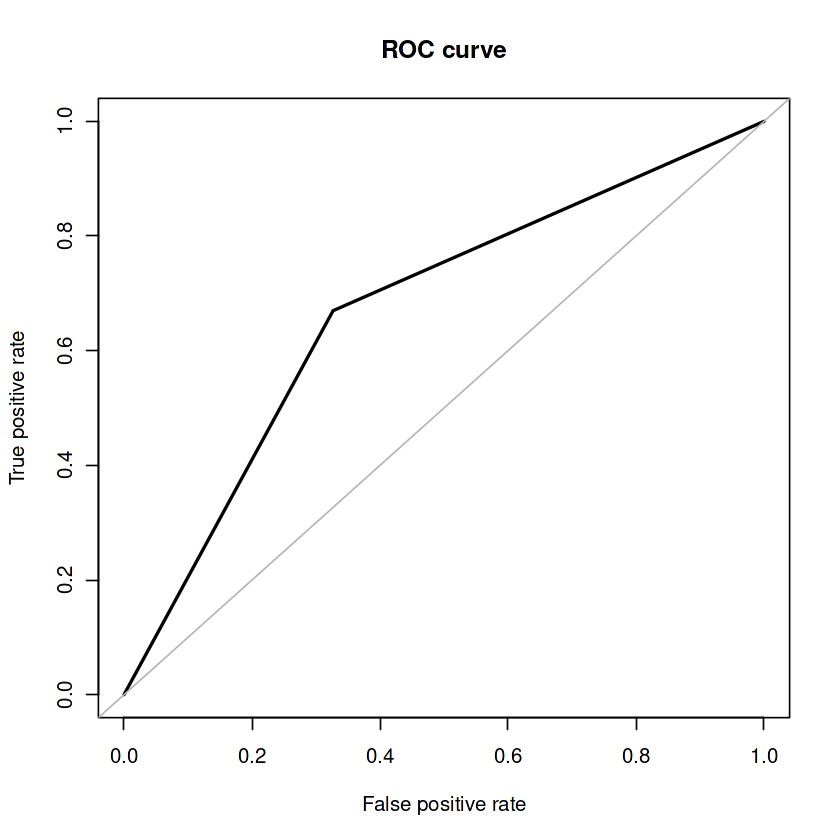

[1] 0.7414345

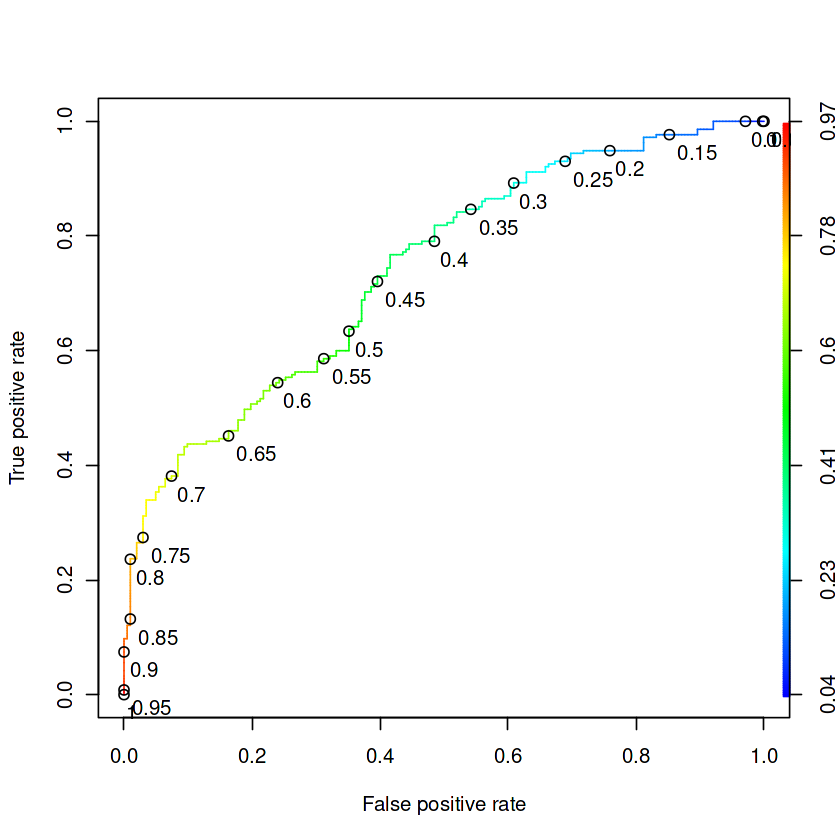

In [26]:
#Try one last revised model:

#there is significance but we could try one additional model using Age, BusinessTravel, MaritalStatus,NumCOmpaniesWorkedfor,TotalWorkingyears, YearswithcurrentManager, and Jobsatisfaction
model2_ANOVA = glm(Attrition~BusinessTravel + MaritalStatus + NumCompaniesWorked + TotalWorkingYears + YearsWithCurrManager + JobSatisfaction, family= "binomial", data = train_under)
summary(model2_ANOVA)

#maybe a better model? 

#vif(model2_ANOVA)

exp(coef(model2_ANOVA))

anova(model2_ANOVA, test = "Chisq")


Attrition_Predict3 = predict(object = model2_ANOVA, newdata = test_under, type = "response")
head(Attrition_Predict3)
summary(Attrition_Predict3)

test_under$predicted3 = ifelse(Attrition_Predict3>=0.5,1,0)
head(test_under$predicted3) 

levels(test_under$Attrition) <- c(0,1) #add levels to work confusion matrix

##CONFUSION MATRIX
table(test_under$predicted3)
confusionMatrix(data=as.factor(test_under$predicted3),
                reference = as.factor(test_under$Attrition),
                positive = "1")

#ROC Curve
roc.curve(test_under$Attrition,test_under$predicted3)

roc_pred2 = prediction(predictions = Attrition_Predict3, labels = test_under$Attrition)
roc_perf2 = performance(roc_pred, "tpr" , "fpr")
plot(roc_perf2,
     colorize = TRUE,
     print.cutoffs.at = seq(0,1,0.05),
     text.adj=c(-0.2,1.7))

as.numeric(performance(roc_pred2,"auc")@y.values)
#AUC is 0.7414 which means the mode has a 73.4% chance to distinguish between a 0 and a 1

In [27]:
library(ipred)
library(caret)
library(ipred)
library(rpart)
library(rpart.plot)
library(lattice)

In [28]:
#I HAD TO DO THIS IN ORDER TO MAKE THE PRED2 AND RMSE BELOW THIS CHUNK TO WORK#

train = train %>%
  mutate(TotalWorkingYears = as.numeric(TotalWorkingYears),
         JobSatisfaction = as.numeric(JobSatisfaction),
         NumCompaniesWorked = as.numeric(NumCompaniesWorked),
         EnvironmentSatisfaction = as.numeric(EnvironmentSatisfaction),
         Attrition = as.numeric(Attrition)) %>%
  mutate(BusinessTravel = as.factor(BusinessTravel),
         JobLevel = as.factor(JobLevel),
         MaritalStatus = as.factor(MaritalStatus),
         Gender = as.factor(Gender),
         Education = as.factor(Education))

train$NumCompaniesWorked[is.na(train$NumCompaniesWorked)] = median(train$NumCompaniesWorked, na.rm = TRUE)
train$TotalWorkingYears[is.na(train$TotalWorkingYears)] = median(train$TotalWorkingYears, na.rm = TRUE)
train$EnvironmentSatisfaction[is.na(train$EnvironmentSatisfaction)] = median(train$EnvironmentSatisfaction, na.rm = TRUE)
train$JobSatisfaction[is.na(train$JobSatisfaction)] = mean(train$JobSatisfaction, na.rm = TRUE)

sapply(train, function(x)sum(is.na(x)))

test = test %>%
  mutate(TotalWorkingYears = as.numeric(TotalWorkingYears),
         JobSatisfaction = as.numeric(JobSatisfaction),
         NumCompaniesWorked = as.numeric(NumCompaniesWorked),
         EnvironmentSatisfaction = as.numeric(EnvironmentSatisfaction),
         Attrition = as.numeric(Attrition)) %>%
  mutate(BusinessTravel = as.factor(BusinessTravel),
         JobLevel = as.factor(JobLevel),
         MaritalStatus = as.factor(MaritalStatus),
         Gender = as.factor(Gender),
         Education = as.factor(Education))

test$NumCompaniesWorked[is.na(test$NumCompaniesWorked)] = median(test$NumCompaniesWorked, na.rm = TRUE)
test$TotalWorkingYears[is.na(test$TotalWorkingYears)] = median(test$TotalWorkingYears, na.rm = TRUE)
test$EnvironmentSatisfaction[is.na(test$EnvironmentSatisfaction)] = mean(test$EnvironmentSatisfaction, na.rm = TRUE)
test$JobSatisfaction[is.na(test$JobSatisfaction)] = median(test$JobSatisfaction, na.rm = TRUE)

sapply(test, function(x)sum(is.na(x)))


train =train %>% 
  mutate_at(vars(JobSatisfaction), ~ifelse(is.na(.), mean(., na.rm = TRUE), .))

test = test %>% 
  mutate_at(vars(JobSatisfaction), ~ifelse(is.na(.), mean(., na.rm = TRUE), .))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `EnvironmentSatisfaction = as.numeric(EnvironmentSatisfaction)`.
Caused by warning:
! NAs introduced by coercion”


Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       0                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      0                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                       0

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `EnvironmentSatisfaction = as.numeric(EnvironmentSatisfaction)`.
Caused by warning:
! NAs introduced by coercion”


Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       0                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      0                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                       0

Bagged CART 

984 samples
 17 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 886, 885, 886, 886, 885, 885, ... 
Resampling results:

  Accuracy   Kappa    
  0.8617708  0.7231852


Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  39.8  4.1
       Yes  9.8 46.3
                            
 Accuracy (average) : 0.8618


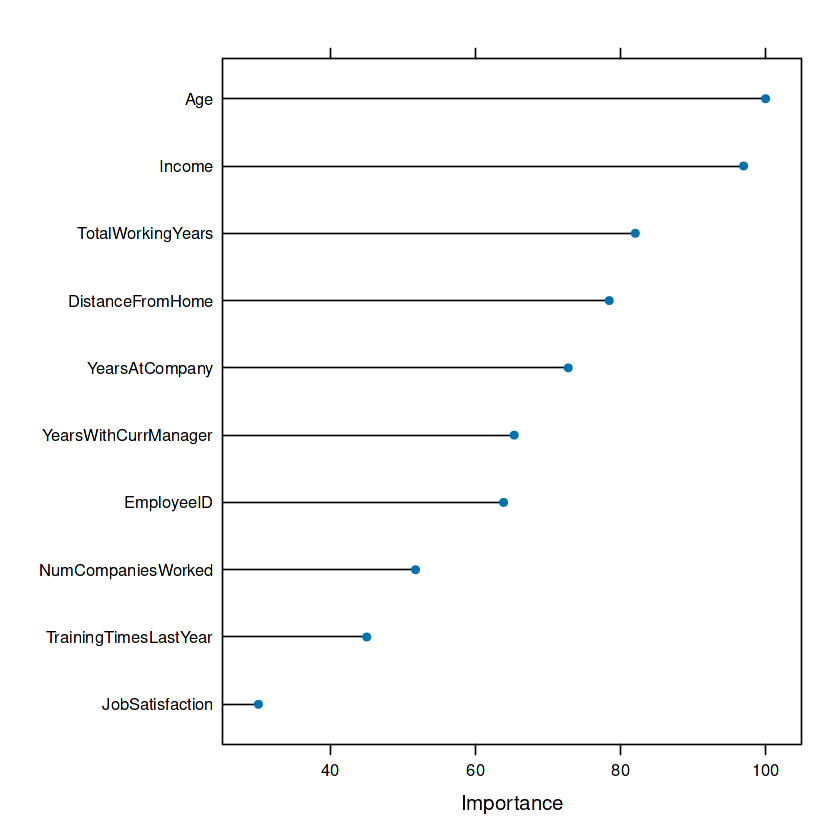

[1] 0.8831338

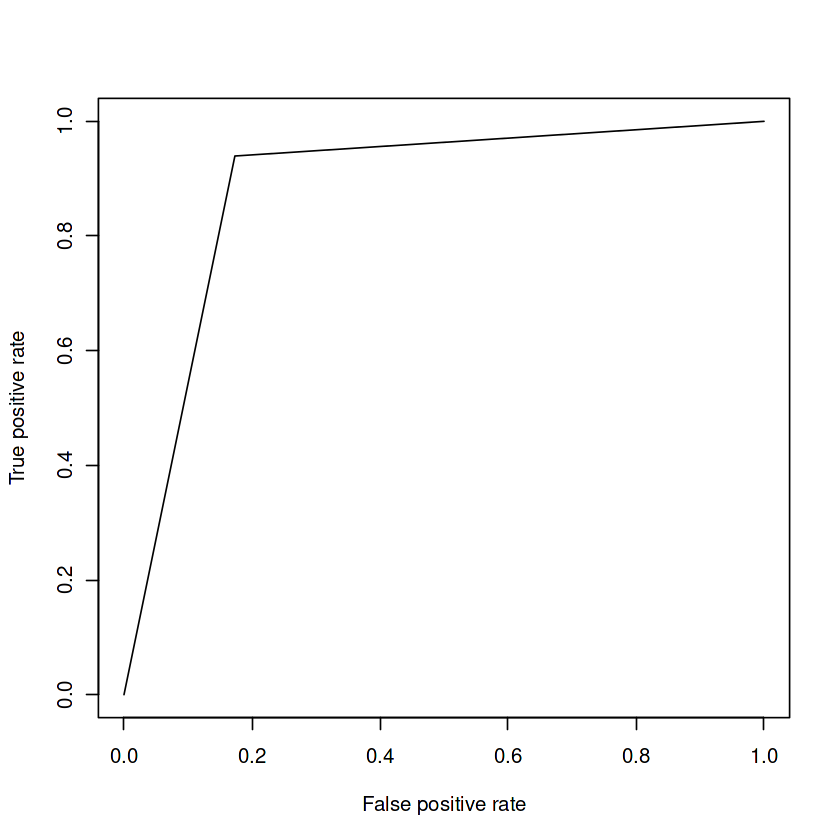

In [29]:
# CV bagged model

#specify 10-fikd criss vakudatuib
ctrl = trainControl(method = "cv", number = 10)

bagged_cv = train(
  Attrition ~ ., 
  data = train_under,
  method = "treebag",
  trControl = ctrl, 
  importance = TRUE
)

# assess results
bagged_cv

#Plot most important variables 
plot(varImp(bagged_cv), 10) 

#Accuracy - 0.837  #KAPPA 0.67

#CONFUSION MATRIX
confusionMatrix(bagged_cv)


#Prediction on Training Data 
#Performance on Training Data 
#Performance on the Test Data

pred_bag <- predict(bagged_cv, train_under)


#Performance on Test Data 
pred_bag_test = predict(bagged_cv, test_under)



### Looks better

#ROC Curve and AUC 
#convert them to numeric from factor for ROC curve 
pred_bag_test = as.numeric(pred_bag_test)

test_under$Attrition = as.numeric(test_under$Attrition)

roc_rpart = prediction(pred_bag_test, test_under$Attrition)

rpart_perform = performance(roc_rpart, measure = "tpr", x.measure = "fpr")

plot(rpart_perform)


### AUC 
auc_rpart = performance(roc_rpart, measure = "auc")
auc_rpart = auc_rpart@y.values[[1]]
auc_rpart

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin





Call:
 randomForest(formula = Attrition ~ ., data = train_under, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.76%
Confusion matrix:
     No Yes class.error
No  420  68  0.13934426
Yes  28 468  0.05645161


Call:
 randomForest(formula = Attrition ~ ., data = train_under, ntree = ntrees) 
               Type of random forest: classification
                     Number of trees: 326
No. of variables tried at each split: 4

        OOB estimate of  error rate: 10.37%
Confusion matrix:
     No Yes class.error
No  414  74  0.15163934
Yes  28 468  0.05645161

'data.frame':	984 obs. of  18 variables:
 $ Age                    : num  37 24 29 49 25 31 43 34 46 38 ...
 $ Attrition              : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ BusinessTravel         : Factor w/ 3 levels "Non-Travel","Travel_Frequently",..: 2 3 3 2 3 3 2 3 3 2 ...
 $ DistanceFromHome       : num  2 2 16 6 2 21 5 2 2 25 ...
 $ Education              : Factor w/ 5 levels "1","2","3","4",..: 4 1 3 1 4 3 3 3 1 3 ...
 $ EmployeeID             : num  1435 2796 4007 1211 4116 ...
 $ Gender                 : Factor w/ 2 levels "Female","Male": 2 2 1 2 1 2 1 2 1 2 ...
 $ JobLevel               : Factor w/ 5 levels "1","2","3","4",..: 2 2 1 3 2 2 2 2 3 2 ...
 $ MaritalStatus          : Factor w/ 3 levels "Divorced","Married",..: 1 2 1 2 1 2 2 2 1 3 ...
 $ Income                 : num  52380 34070 22100 29960 27850 ...
 $ NumCompaniesWorked     : num  1 0 8 2 0 1 8 1 9 1 ...
 $ StandardHours          : num  8 8 8 8 8 8 8 8 8 8 ...
 $ TotalWorkingYears      : num 

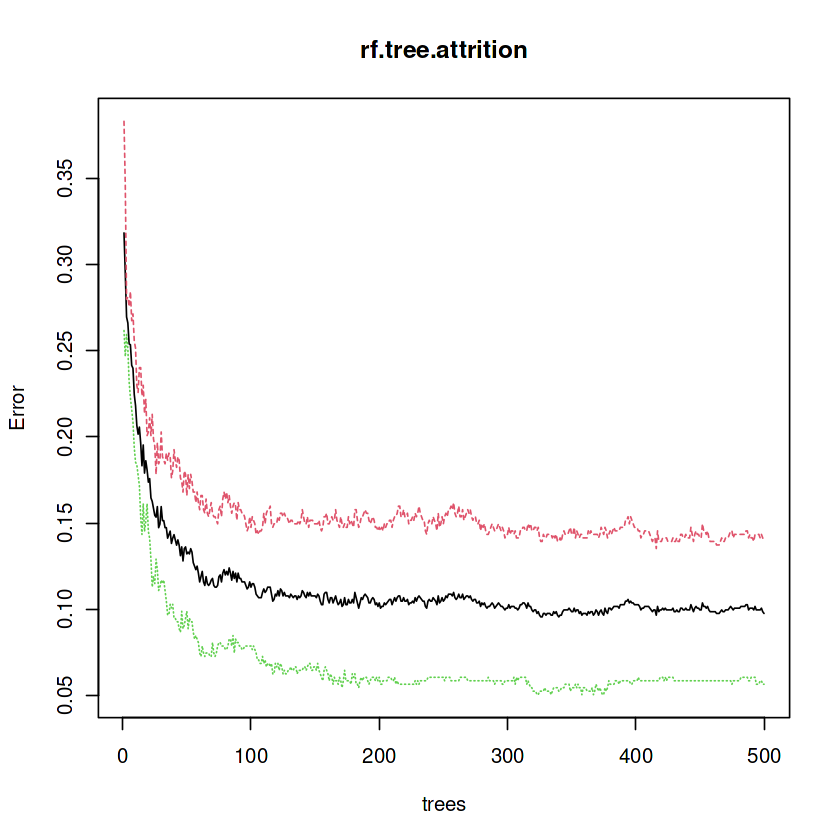

A performance instance
  'Area under the ROC curve'

[1] 0.9500345

,Overall
,<dbl>
Age,53.528845
BusinessTravel,15.106161
DistanceFromHome,39.530624
Education,25.225126
EmployeeID,30.982905
Gender,7.169701
JobLevel,24.634578
MaritalStatus,20.450246
Income,55.260818


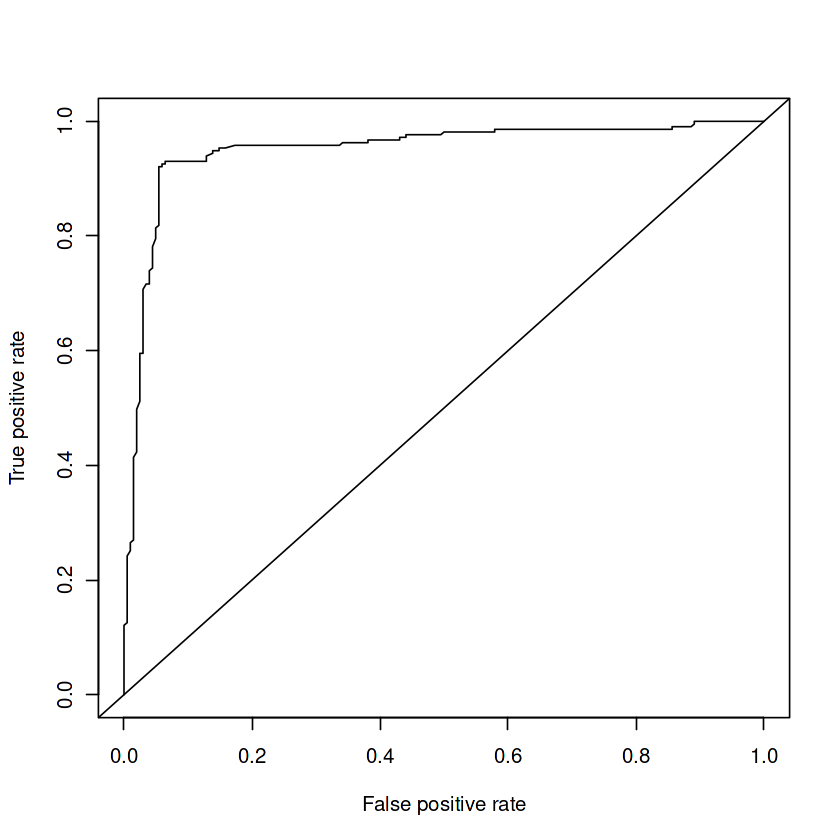

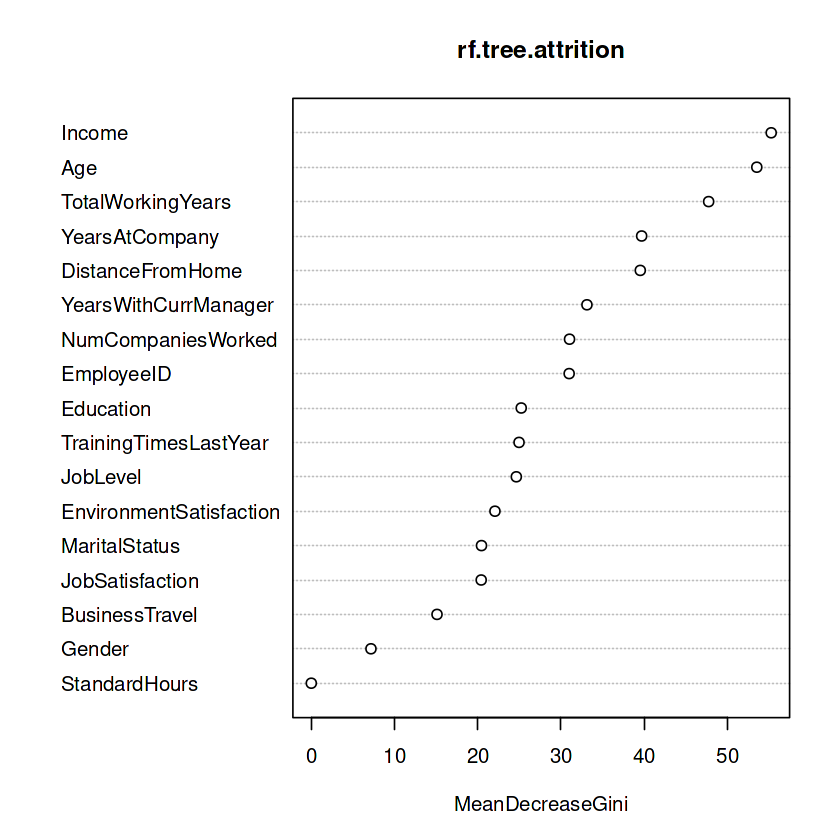

In [30]:
#RANDOM FOREST

library(randomForest)
rf.tree.attrition = randomForest(Attrition ~., data=train_under, ntree = 500)
rf.tree.attrition

plot(rf.tree.attrition)


#Model tunning 
## we will build a model with the number of trees that give us the minimum OOB error 
ntrees = which.min(rf.tree.attrition$err.rate[,1])

rf.tree.attrition1 = randomForest(Attrition ~., data = train_under, ntree = ntrees)
rf.tree.attrition1

#Prediction and COnfusion Matrix 
str(train_under)
str(test_under)

train_under$Attrition = as.factor(train_under$Attrition)

test_under$Attrition = as.factor(test_under$Attrition)

rf.trees.predict = predict(rf.tree.attrition, newdata = test_under, type="class")


#Model Performance  
require(ROCR)

tree.attrition.predict2 <- predict(rf.tree.attrition, test_under, type="prob")
predROC <- prediction(tree.attrition.predict2[,2], test_under$Attrition)
perfROC <- performance(predROC, "tpr", "fpr")
plot(perfROC)
abline(a=0, b=1)


#CALC Area under the curve 
perfROC = performance(predROC, "auc")
perfROC
perfROC@y.values[[1]]

#Variable Importance 
varImp(rf.tree.attrition)

varImpPlot(rf.tree.attrition)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”



Call:
 randomForest(formula = Attrition ~ ., data = train, na.action = na.roughfix) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 5

          Mean of squared residuals: 0.03470071
                    % Var explained: 74.27

[1] 459

[1] 0.1860586

Warning message in randomForest.default(x, y, mtry = mtryStart, ntree = ntreeTry, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in randomForest.default(x, y, mtry = mtryCur, ntree = ntreeTry, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


-0.02984973 0.01 


Warning message in randomForest.default(x, y, mtry = mtryCur, ntree = ntreeTry, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


0.04043683 0.01 


Warning message in randomForest.default(x, y, mtry = mtryCur, ntree = ntreeTry, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


0.03825736 0.01 


Warning message in randomForest.default(x, y, mtry = mtryCur, ntree = ntreeTry, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


0.01331563 0.01 


Warning message in randomForest.default(x, y, mtry = mtryCur, ntree = ntreeTry, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


0.001243682 0.01 


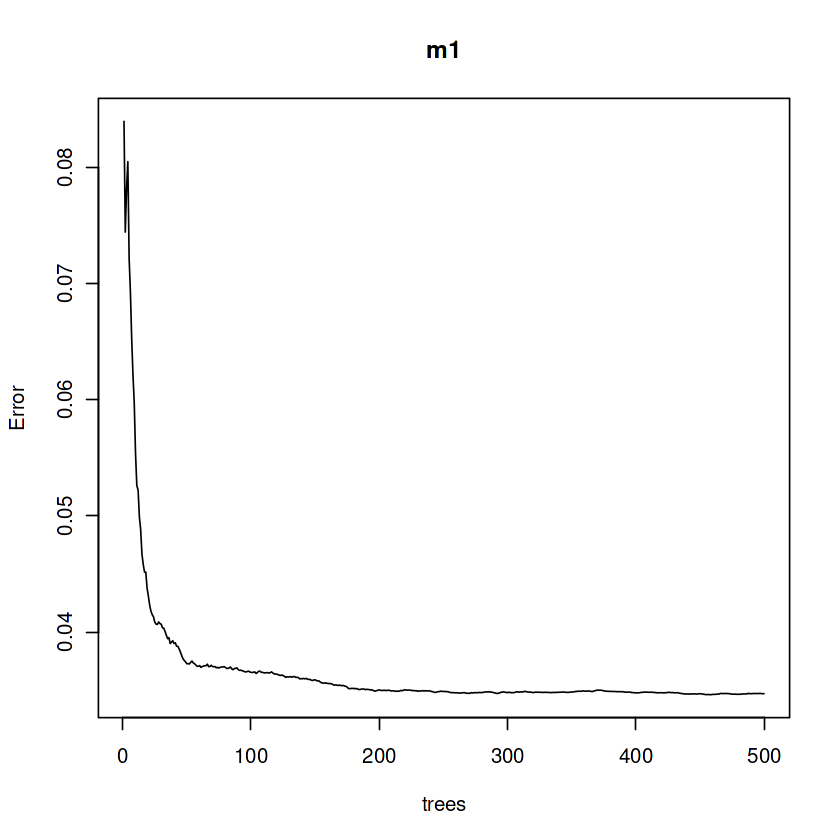

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


   user  system elapsed 
 13.186   0.120  13.306 

[1] 64

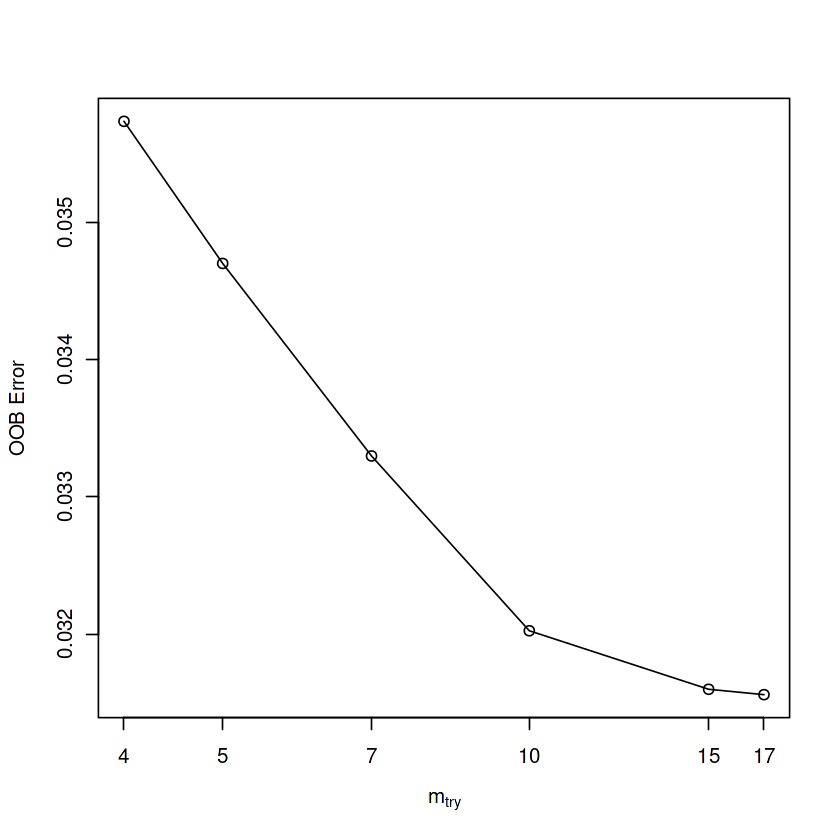

In [31]:
set.seed(123) #For reproducibility

#Making another model for Random Forest, na.roughfix was replaced with na.omit because I keep getting errors
m1 = randomForest(
  formula = Attrition ~ .,
  data = train,
  na.action = na.roughfix
)
m1

#Plotting the model will illustarte the error rate as we average across more trees
plot(m1) #Error rate stabilizes at around 50 trees, error rate is based on the OOB sample

#number of trees with lowest MSE
which.min(m1$mse) #355  was the answer

#RMSE of this optimal random forest
sqrt(m1$mse[which.min(m1$mse)]) #0.1857795

#I SKIPPED THE OPTIONAL CODE PART OF THE SLIDES AND WENT TO INITIAL TUNING#

features = setdiff(names(train), "Attrition")

set.seed(123)
m2 = tuneRF(
  x = train[features],
  y = train$Attrition,
  ntreeTry = 500,
  mtryStart = 5,
  stepFactor = 1.5,
  improve = 0.01, #error should lower by 0.01 or more
  trace = FALSE #to not show real time progress
)

#To perform a larger grid search across several hyperparameters we'll need to create a grid and loop through each hyperparameter combination and evaluate the model
#Full grid search with ranger package
#randomForest speed

 system.time(
  canterra_randomForest <- randomForest(
    formula = Attrition ~ .,
    data = train,
    ntree = 500,
    mtry = floor(length(features) / 3)
  )) #Make sure you use the <- symbol for the randomforest name

#Using ranger which is supposed to be faster than randomForest which is above but crossed out with hashtags
#system.time(
 # canterra_ranger <- ranger(
  #  formula = Attrition ~ .,
   # data = train,
    #num.trees = 500,
    #m#try = floor(length(features)/3)
 # )) #Make sure you use the <- symbol for the ranger name



#To perform grid search we want to construct our grid of hyperparameters,
#We will search through various models with varying mtry, minimum node size, and sample size

#Hyperparameter grid search
hyper_grid = expand.grid(
  mtry = seq(4, 10, by = 2),
  node_size = seq(3, 9, by = 2), #Minimum no. of samples in the terminal nodes
  sampe_size = c(.55, .632, .70, .80), #size of bootstrap samples to train on
  OOB_RMSE = 0
)

#Total number of combinations
nrow(hyper_grid)

#Looping through each hyperparameter combination and apply 500 trees
#the random number seed allows to consistently sample the same observations for each sample size

#for(i in 1:nrow(hyper_grid)){
  #train model
  #model_grid = ranger(
    #formula = Attrition ~ .,
    #data = train,
    #num.trees = 500,
    #mtry = hyper_grid$mtry[i],
    #min.node.size = hyper_grid$node_size[i],
    #sample.fraction = hyper_grid$sampe_size[i],
    #seed = 123)
  #hyper_grid$OOB_RMSE[i] = sqrt(model_grid$prediction.error) #add OOB error to grid
#}


#hyper_grid %>%
  #arrange(OOB_RMSE) %>%
  #head(10)

In [32]:
library(janitor)


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [33]:
#Although, random forests typically perform quite well with
#categorical variables in their original columnar form, it is worth
#checking to see if alternative encodings can increase performance.

# one-hot encode our categorical variables
one_hot = dummyVars(~., train, fullRank = FALSE)
train_hot = predict(one_hot, train) %>% as.data.frame()

#Make ranger compatibile names
names(train_hot) = make.names(names(train_hot), allow_ = FALSE)

# hyperparameter grid search --> same as above but with increased mtry values
hyper_grid_2 = expand.grid(
  mtry = seq(10, 100, by = 20),
  node_size = seq(3, 9, by = 2),
  sampe_size = c(.55, .632, .70, .80),
  OOB_RMSE = 0
)

#for(i in 1:nrow(hyper_grid_2)){
  #model_grid_2 <- ranger(
    #formula = Attrition ~ .,
    #data = train_hot,
    #num.trees = 500,
    #mtry = hyper_grid_2$mtry[i],
    #min.node.size = hyper_grid_2$node_size[i],
    #sample.fraction = hyper_grid_2$sampe_size[i],
    #seed = 123)
  #hyper_grid_2$OOB_RMSE[i] <- sqrt(model_grid_2$prediction.error) 
#}

In [34]:
#The best RF model we have found retains categorical variables and uses 10 variables and terminal node size of 7 observations and sample
#size 80%; Lets repeat this model to get a better expectation of the error rate

#OOB_RMSE = vector(mode = "numeric", length = 100)

#for(i in seq_along(OOB_RMSE)){
 # optimal_ranger = ranger(
  #formula = Attrition ~.,
  #data = train_hot,
  #num.trees = 500,
  #mtry = 50,
  #min.node.size = 7,
  #sample.fraction = .8,
  #importance = "impurity")
  #OOB_RMSE[i] = sqrt(optimal_ranger$prediction.error)
#}